# Model Climate-Biosphere Interactions

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd
import os

## Constants and parameters

In [3]:
# Define the constants and parameters
# (a) Carbon cycle parameters 
ca0 = 589  # Pre-industrial atmospheric carbon stock (PgC)
ct0 = 1875  # Pre-industrial terrestrial carbon stock (PgC)
cm0 = 900  # Pre-industrial ocean mixed layer carbon stock (PgC)

lambda_climate = 1.8  # Transient climate sensitivity (K)
tau = 4  # Climate lag (years)

NPP0 = 55  # Pre-industrial net primary productivity (PgC/year)
w0 = 0.1  # Solubility pump rate (year^-1)
wT = 0.1  # Weakening of overturning circulation with climate change (1/K)
D = 1  # Atmosphere-ocean CO2 diffusion (year^-1)
r = 12.5  # Revelle factor (buffer factor)
DT = 0.0423  # Reduction of solubility with temperature (1/K)
B0 = 13 # Pre-industrial biological pump (PgC/year)
BT = 0.032 # Temperature dependence of biological pump (1/K)
QR = 1.72  # Temperature dependence of respiration
KC = 0.3  # CO2 fertilization effect

# (b) Parameters for biosphere-climate interactions
theta = 0.26  # Exponent in biodiversity–function relationship
ICC = 0.05  # (0-0.1) Effect of climate change on biodiversity (1/K)
rg = 0.025  # (0.0125-0.0500) Response relaxation rate (1/year)
vmax = 0.02  # (0.01-0.04) Maximum response rate (K/year)
KA = 55  # (25-95) Terrestrial carbon storage loss due to response lag (PgC/K)
pT = 22.5  # (10-40) Permafrost thaw temperature response (PgC/K)
BA = 0.00019  # (0-0.00038) Acidification effect on marine biological pump (1/μatm)
BTB = 0.007  # (0-0.014) Temperature effect on marine biological pump (1/K)

### Time and RCP scenario dependent parameters

In [5]:
# Time and RCP scenario dependent parameters
# Define the RCP scenarios
scenarios = [2.6, 4.5, 6.0, 8.5]

# Emissions and LUC
emissions = {}   # Fossil fuel emissions (PgC/year) depending on RCP scenarios
LUC = {}  # Land-use emissions (PgC/year) depending on RCP scenarios

## Load emissions and LUC for RCP scenarios
current_dir = os.path.dirname(os.path.abspath('pycopancore_bbc')) # Get the current script directory
for scenario in scenarios: 
    # Loop through the scenarios and load the corresponding CSV files
    file_path_emissions = os.path.join(current_dir, 'input', f'Emissions{scenario}.csv')
    emissions[f'RCP{scenario}'] = pd.read_csv(file_path_emissions, header=None)
    emissions[f'RCP{scenario}'].columns = ['year', 'emissions']

    file_path_LUC = os.path.join(current_dir, 'input', f'LUC{scenario}.csv')
    LUC[f'RCP{scenario}'] = pd.read_csv(file_path_LUC, header=None)
    LUC[f'RCP{scenario}'].columns = ['year', 'LUC']
   

## Get emissions for certain time and RCP scenario
def emissions_RCP(t, scenario=8.5):
    year = np.floor(t)
    if scenario in scenarios:
        if year <= 2100:
            return emissions[f'RCP{scenario}'].loc[emissions[f'RCP{scenario}']['year'] == year, 'emissions'].values[0]
        else:
            return 0
    if scenario == 0:
        return 0
    else:
        raise ValueError(f"Invalid scenario, possible RCP scenarios are: {scenarios}")

## Get LUC for certain time and RCP scenario
def LUC_RCP(t, scenario=8.5):
    year = np.floor(t)
    if scenario in scenarios:
        if year <= 2100:
            return LUC[f'RCP{scenario}'].loc[LUC[f'RCP{scenario}']['year'] == year, 'LUC'].values[0]
        else:
            return 0
    if scenario == 0:
        return 0
    else:
        raise ValueError(f"Invalid scenario, possible RCP scenarios are: {scenarios}")

# Impact on BD
# Id   # Direct human impacts on biodiversity

## Get Id for certain time and RCP scenario
## Formular from Hannahs code (\pycopancore-BBC-model\pycopancore\model_components\BBC\implementation\world.py)
def Id_RCP(t, scenario=8.5, impact=0):
    if scenario in scenarios:
        additional_impact = {
            2.6 : 0.1, 
            4.5 : 0.12,
            6.0 : 0.14, 
            8.5 : 0.18}
        
        # continuous destruction
        #return 0.1 * min((t - 1765) / (2000 - 1765), 1) + additional_impact[scenario] * max(0, (t - 2000) / (2100 - 2000))
        
        # continuous destruction until impact reaches 'impact'
        #return  min(0.1 * min((t - 1765) / (2000 - 1765), 1) + additional_impact[scenario] * max(0, (t - 2000) / (2100 - 2000)), impact)

        # shock impact at 2100
        if t <= 2100:
            return 0.1 * min((t - 1765) / (2000 - 1765), 1) + additional_impact[scenario] * max(0, (t - 2000) / (2100 - 2000))
        else:
            return impact
        
        # no more destruction after 2100
        #return 0.1 * min((t - 1765) / (2000 - 1765), 1) + additional_impact[scenario] * min(max(0, (t - 2000) / (2100 - 2000)), additional_impact[scenarios.index(scenario)])
    
    if scenario == 0:
        return impact
    else:
        raise ValueError(f"Invalid scenario, possible RCP scenarios are: {scenarios}")

## Variables
Just to get the overview

In [6]:
# Variables
# t   # Year

# T   # Current GMST (K)
# Delta_T   # Change in GMST from pre-industrial to current (K) 
# z   # GMST to which species are currently best adapted (K)
# Delta_z   # Change in best adapted GMST from pre-industrial to current (?) (K) 

# ca   # Atmospheric carbon
# ct   # Terrestrial carbon
# cm   # Ocean mixed layer carbon
# cp   # Carbon from permafrost thaw
# cs   # System carbon (contributed by fossil fuel emissions and biological pump)

# Carbon types 
carbon_types = ['ca', 'ct', 'cm', 'cp', 'cs']
# Carbon indices in the output of model
carbon_indices = range(2, 7)

## Initial conditions

In [7]:
# Initial conditions
Delta_T0 = 0  # Initial temperature anomaly (°C)
Delta_z0 = 0  # Initial response lag (°C)

ca_init = ca0  # Initial atmospheric carbon stock (PgC)
ct_init = ct0  # Initial terrestrial carbon stock (PgC)
cm_init = cm0  # Initial ocean mixed layer carbon stock (PgC)
cp_init = 0  # Initial carbon from permafrost thaw (PgC), set to zero as per the paper
cs_init = 0  # Initial change in 'system carbon' (PgC), set to zero as per the paper

## Colors for plotting

In [8]:
# Carbon
colors_carbon = {
    'ca': 'skyblue',
    'ct': 'green',
    'cm': 'steelblue',
    'cp': '#CC7722',
    'cs': 'grey'
}
# Temperature for different RCP scenarios
colors_RCP = {
    2.6: '#003366',
    4.5: '#66c2ff',
    6.0: '#ff6600',
    8.5: '#cc3333'
}

# Model

In [9]:
# Define the model
def model(t, y, params, scenario, impact):
    Delta_T, Delta_z, ca, ct, cm, cp, cs = y 
    ca0, ct0, cm0, lambda_climate, tau, NPP0, w0, wT, D, r, DT, B0, BT, QR, KC, theta, ICC, rg, vmax, KA, pT, BA, BTB = params
    scenario = scenario
    impact = impact

    # 2.1. Land
    # 2.1.1. Response lag & 2.1.2. Biodiversity loss
    response_lag = np.abs(Delta_T - Delta_z)

    ## Globally aggregated measure of biodiversity I
    Id_t = Id_RCP(t, scenario, impact)
    I = np.maximum(0, 1 - ICC * response_lag - Id_t)
            
    ## Biodiversity-dependent further slowing of species responses H
    H = I ** theta 

    ## Terrestrial carbon carrying capacity K
    if ca <= 0:
        ca = 1e-6  # Avoid log(0) which is undefined
    K = H * ((1 + KC * np.log(ca / ca0)) * ct0 * QR ** (-Delta_T / 10)) - KA * response_lag

    ## Terrestrial carbon equation dcdt
    LUC_t = LUC_RCP(t, scenario)
    dctdt = (NPP0 / ct0) * (QR ** (Delta_T / 10)) * (K - ct) - LUC_t

    ## Best-adapted GMST equation dDelta_zdt
    dDelta_zdt = vmax * H * np.tanh(rg * (Delta_T - Delta_z) / vmax) 

    # Temperature anomaly equation
    dDelta_Tdt = (lambda_climate / np.log(2) * np.log(ca / ca0) - Delta_T) / tau

    # 2.1.3. Permafrost thaw
    ## Permafrost carbon equation dcpdt
    dcpdt = pT * max(dDelta_Tdt, 0)

    # 2.2. Ocean    
    ## Marine biological pump partial pressure P
    cm = np.maximum(1e-6, cm)
    denominator = np.maximum(1e-6, 1 - DT * Delta_T)
    p = ca0 * ((cm / cm0) ** r) / denominator
    
    ## Marine biological pump efficiency B
    B = B0 * (1 - BT * Delta_T - BTB * Delta_T) * (1 - BA * (p - ca0))
    
    ## Ocean mixed layer carbon equation dcmdt
    dcmdt = (D * cm0 / (r * ca0)) * (ca - p) + B0 - B - w0 * (1 - wT * Delta_T) * (cm - cm0)

    # 2.3. Atmosphere
    ## System carbon equation dcsdt
    e_t = emissions_RCP(t, scenario)
    dcsdt = e_t - w0 * (1 - wT * Delta_T) * (cm - cm0) - (B - B0)
    
    ## Atmospheric carbon equation based on conservation dcadt
    ca_conservation = ca0 + ct0 + cm0 + cs + cp - ct - cm
    dcadt = dcsdt + dcpdt - dctdt - dcmdt
    
    return [dDelta_Tdt, dDelta_zdt, dcadt, dctdt, dcmdt, dcpdt, dcsdt]

## Run Model

In [10]:
# Define initial conditions and parameters
y0 = [Delta_T0, Delta_z0, ca_init, ct_init, cm_init, cp_init, cs_init]
params = [ca0, ct0, cm0, lambda_climate, tau, NPP0, w0, wT, D, r, DT, B0, BT, QR, KC, theta, ICC, rg, vmax, KA, pT, BA, BTB]

# Define time span for the solution
t_span = (1765, 4000) 
t = np.linspace(t_span[0], t_span[1], t_span[1] - t_span[0])

# Define range for direct human impact on biodiversity (Id) we want to try
impact_range = np.arange(0, 0.8, 0.1)

### Pre-industrial state (emissions = 0, LUC = 0) but shock-direct-impact on biodiversity

#### Carbon

In [11]:
# Define output directory
output_dir = 'output_plots'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [12]:
legend_descriptions = {
    'ca': 'Atmospheric carbon',
    'ct': 'Terrestrial carbon',
    'cm': 'Ocean mixed layer carbon',
    'cp': 'Carbon from permafrost thaw',
    'cs': 'System carbon'
}

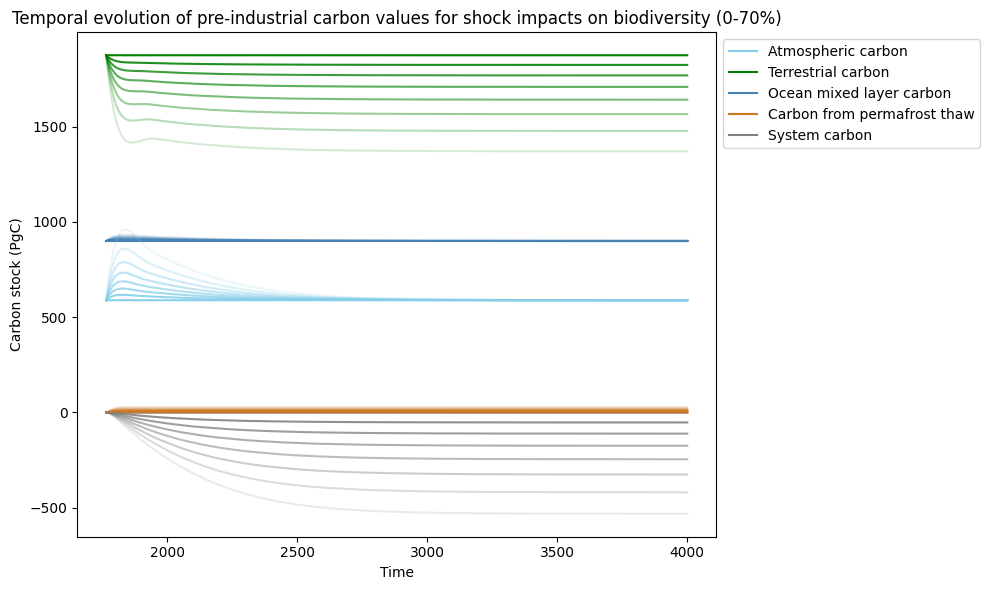

In [13]:
plt.figure(figsize=(10, 6))

# Plot carbon stocks
for i, impact in enumerate(impact_range):
    alpha = 1.0 - 0.12 * i  # Adjust alpha based on impact level
    for var, idx in zip(carbon_types, carbon_indices):
        solution = solve_ivp(model, t_span, y0, args=(params, 0, impact), dense_output=True)
        if i == 0:
            plt.plot(t, solution.sol(t)[idx], color=colors_carbon[var], alpha=alpha, label=legend_descriptions[var])
        else:
            plt.plot(t, solution.sol(t)[idx], color=colors_carbon[var], alpha=alpha)

plt.xlabel('Time')
plt.ylabel('Carbon stock (PgC)')
plt.legend()
plt.title(f'Temporal evolution of pre-industrial carbon values for shock impacts on biodiversity ({round(impact_range[0]*100)}-{round(impact_range[-1]*100)}%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'Temporal_evolution_PI_carbon_shock_impacts.png'), bbox_inches='tight')
plt.show()

#### Temperature

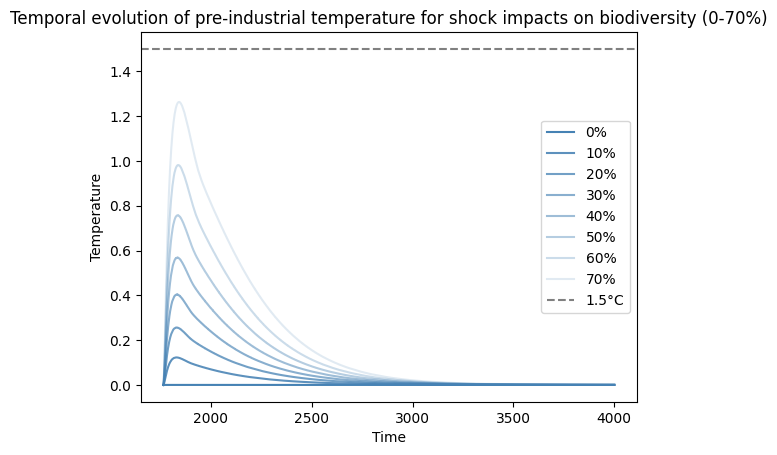

In [14]:
# Plot temperature
for i, impact in enumerate(impact_range):
    solution = solve_ivp(model, t_span, y0, args=(params, 0, impact), dense_output=True)
    alpha = 1.0 - 0.12 * i  # Adjust alpha based on impact level
    plt.plot(t, solution.sol(t)[0].T, color='steelblue', alpha=alpha, label=f'{round(impact*100)}%')

plt.axhline(1.5, color='grey', linestyle='--', label='1.5°C')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.title(f'Temporal evolution of pre-industrial temperature for shock impacts on biodiversity ({round(impact_range[0]*100)}-{round(impact_range[-1]*100)}%)')
plt.savefig(os.path.join(output_dir, f'Temporal_evolution_PI_temperature_shock_impacts.png'), bbox_inches='tight')
plt.show()

### RCP Scenarios until 2100

#### Carbon

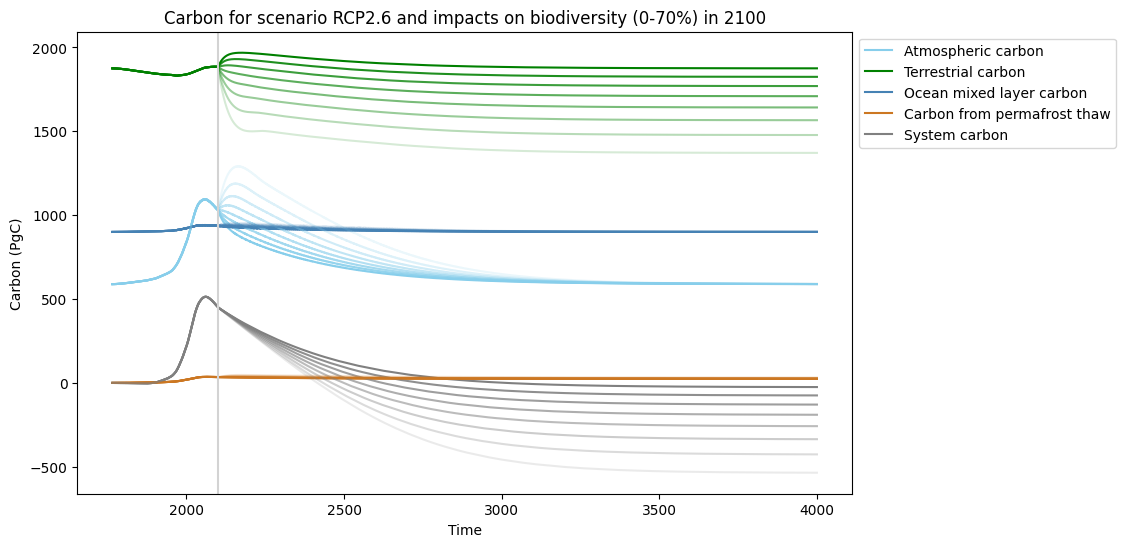

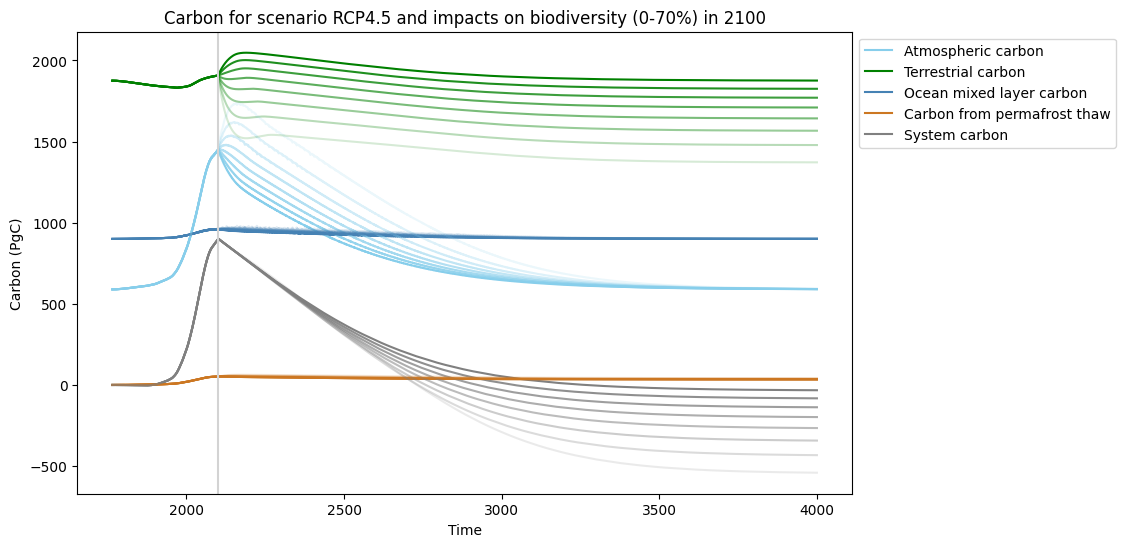

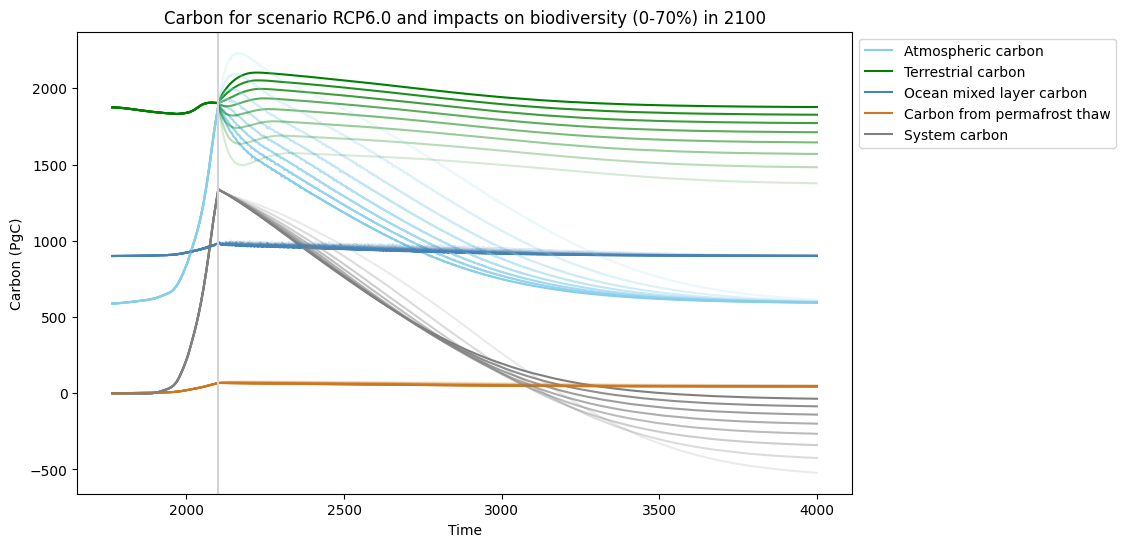

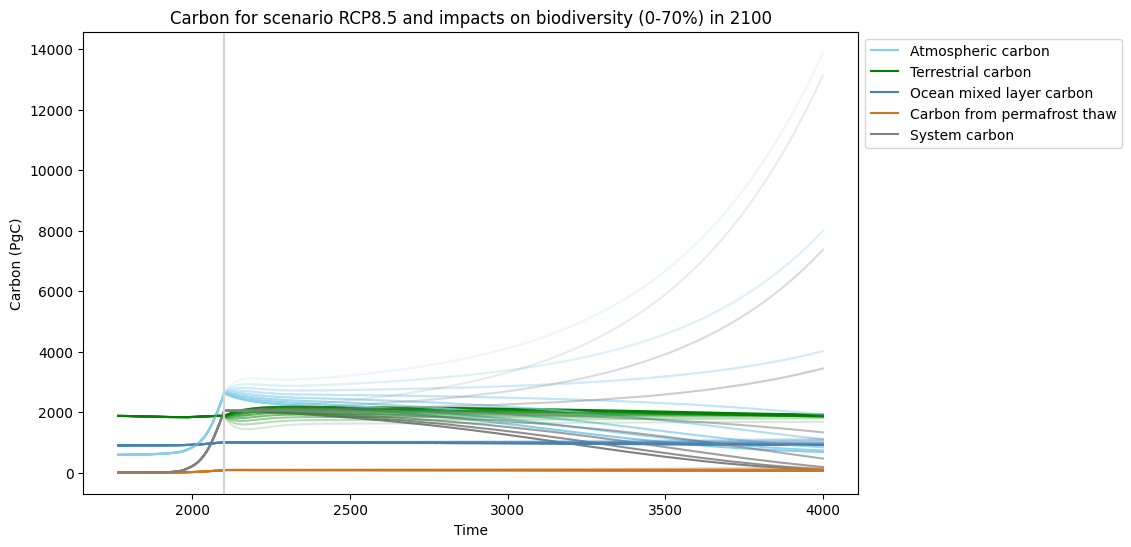

In [15]:
# Plot the carbon for different scenarios
for scenario in scenarios:
    plt.figure(figsize=(10, 6))

    for i, impact in enumerate(impact_range):
        solution = solve_ivp(model, t_span, y0, args=(params, scenario, impact), dense_output=True)
        alpha = 1.0 - 0.12 * i  # Adjust alpha based on impact level

        for var, idx in zip(carbon_types, carbon_indices):
            if i == 0:
                plt.plot(t, solution.sol(t)[idx], color=colors_carbon[var], alpha=alpha, label=legend_descriptions[var])
            else:
                plt.plot(t, solution.sol(t)[idx], color=colors_carbon[var], alpha=alpha)
        
    plt.axvline(2100, color='lightgrey')
    plt.xlabel('Time')
    plt.ylabel('Carbon (PgC)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(f'Carbon for scenario RCP{scenario} and impacts on biodiversity ({round(impact_range[0]*100)}-{round(impact_range[-1]*100)}%) in 2100')
    plt.savefig(os.path.join(output_dir, f'Carbon_for_RCP{scenario}_impacts_on_biodiv_2100.png'), bbox_inches='tight')
    plt.show()

#### Temperature

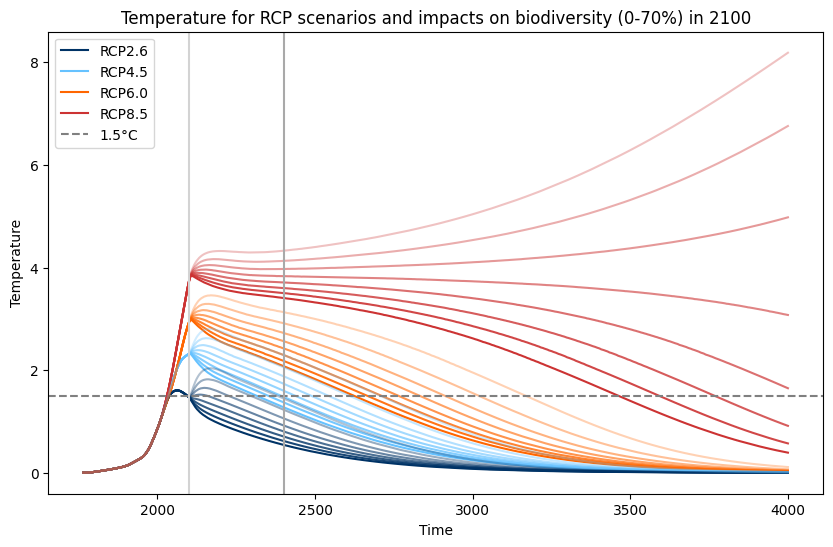

In [77]:
plt.figure(figsize=(10, 6))    

# Plot the temperature
for i, impact in enumerate(impact_range):
    for scenario in scenarios:
        solution = solve_ivp(model, t_span, y0, args=(params, scenario, impact), dense_output=True)
        alpha = 1.0 - 0.1 * i  # Adjust alpha based on impact level
        if i == 0:
            plt.plot(t, solution.sol(t)[0].T, color=colors_RCP[scenario], alpha=alpha, label=f'RCP{scenario}')
        else:
            plt.plot(t, solution.sol(t)[0].T, color=colors_RCP[scenario], alpha=alpha)

plt.axhline(1.5, color='grey', linestyle='--', label='1.5°C')
plt.axvline(2100, color='lightgrey')
#plt.axvline(2400, color='darkgrey') # for plot with line at 2400 (end of acceptable recovery time)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.title(f'Temperature for RCP scenarios and impacts on biodiversity ({round(impact_range[0]*100)}-{round(impact_range[-1]*100)}%) in 2100')
plt.savefig(os.path.join(output_dir, f'Temperature_for_RCP{scenario}_impacts_on_biodiv_2100.png'), bbox_inches='tight')
plt.show()

# Resilience Assessment

## Return Time 

Get Return Time for each scenario for different maximum impact values. 

In [17]:
T_threshold = 1.5 # 1.5°C
acceptable_recovery_time = 300 # in years

In [18]:
def return_time(scenario, impact, T_threshold=1.5):
    solution = solve_ivp(model, t_span, y0, args=(params, scenario, impact), dense_output=True)
    temp_solution = solution.sol(t)[0]
    temp_under_threshold = temp_solution <= T_threshold
    for i in range(len(temp_under_threshold)):
        if all(temp_under_threshold[i:]):
            return round(t[i]-2100)
    return None

In [19]:
# Calculate Return Time for the 4 Scenarios
for impact in impact_range:
    print(f"Recovery Times for {round(impact,1)} maximum impact." )
    for scenario in scenarios:
        time = return_time(scenario, impact, T_threshold)
        if time is None:
            print(f'RCP{scenario} : No return below {T_threshold}°C.')
        else:
            print(f'RCP{scenario} : {time} years.')

Recovery Times for 0.0 maximum impact.
RCP2.6 : -5 years.
RCP4.5 : 215 years.
RCP6.0 : 524 years.
RCP8.5 : 1363 years.
Recovery Times for 0.1 maximum impact.
RCP2.6 : -5 years.
RCP4.5 : 252 years.
RCP6.0 : 565 years.
RCP8.5 : 1492 years.
Recovery Times for 0.2 maximum impact.
RCP2.6 : -5 years.
RCP4.5 : 292 years.
RCP6.0 : 611 years.
RCP8.5 : 1668 years.
Recovery Times for 0.3 maximum impact.
RCP2.6 : -5 years.
RCP4.5 : 337 years.
RCP6.0 : 664 years.
RCP8.5 : No return below 1.5°C.
Recovery Times for 0.4 maximum impact.
RCP2.6 : 58 years.
RCP4.5 : 388 years.
RCP6.0 : 732 years.
RCP8.5 : No return below 1.5°C.
Recovery Times for 0.5 maximum impact.
RCP2.6 : 126 years.
RCP4.5 : 442 years.
RCP6.0 : 812 years.
RCP8.5 : No return below 1.5°C.
Recovery Times for 0.6 maximum impact.
RCP2.6 : 196 years.
RCP4.5 : 509 years.
RCP6.0 : 920 years.
RCP8.5 : No return below 1.5°C.
Recovery Times for 0.7 maximum impact.
RCP2.6 : 280 years.
RCP4.5 : 604 years.
RCP6.0 : 1068 years.
RCP8.5 : No return be

In [45]:
# Same as above but saved in a DataFrame
data = []

for scenario in scenarios:
    for impact in impact_range:
        time = return_time(scenario, impact, T_threshold)
        if time is None:
            time = f'No return below {T_threshold}°C possible.'
        data.append([round(impact, 1), f'RCP{scenario}', time])

return_time_data = pd.DataFrame(data, columns=['Impact', 'Scenario', 'Recovery Time [yrs after 2100]'])

In [46]:
# Print the DataFrame
return_time_data

,Impact,Scenario,Recovery Time [yrs after 2100]
0,0.0,RCP2.6,-5
1,0.1,RCP2.6,-5
2,0.2,RCP2.6,-5
3,0.3,RCP2.6,-5
4,0.4,RCP2.6,58
5,0.5,RCP2.6,126
6,0.6,RCP2.6,196
7,0.7,RCP2.6,280
8,0.0,RCP4.5,215
9,0.1,RCP4.5,252


## Maximum bearable impact for acceptable recovery time

In [58]:
bearable_impact = []

def bearable_impacts(acceptable_recovery_time):
    for _, row in return_time_data.iterrows():
        recovery_time = row['Recovery Time [yrs after 2100]']
        if isinstance(recovery_time, int) and recovery_time <= acceptable_recovery_time: # check if is number and smaller than acceptable recovery time
            bearable_impact.append(row)

In [59]:
bearable_impacts(acceptable_recovery_time)
bearable_impact_df = pd.DataFrame(bearable_impact)
bearable_impact_df

,Impact,Scenario,Recovery Time [yrs after 2100]
0,0.0,RCP2.6,-5
1,0.1,RCP2.6,-5
2,0.2,RCP2.6,-5
3,0.3,RCP2.6,-5
4,0.4,RCP2.6,58
5,0.5,RCP2.6,126
6,0.6,RCP2.6,196
7,0.7,RCP2.6,280
8,0.0,RCP4.5,215
9,0.1,RCP4.5,252


In [61]:
def find_max_impact(df):
    max_impact_df = df.loc[df.groupby('Scenario')['Impact'].idxmax()].reset_index(drop=True)
    return max_impact_df

max_impact_df = find_max_impact(bearable_impact_df)
max_impact_df

,Impact,Scenario,Recovery Time [yrs after 2100]
0,0.7,RCP2.6,280
1,0.2,RCP4.5,292


In [76]:
def scenario_report(df, scenarios):
    report = []
    for scenario in scenarios:
        scenario_str = f"RCP{scenario}"
        if scenario_str in df['Scenario'].values:
            max_impact = df[df['Scenario'] == scenario_str]['Impact'].values[0]
            report.append(f"Maximum bearable impact for {scenario_str} is: {max_impact*100} % biodiversity reduction.")
        else:
            report.append(f"Maximum bearable impact for {scenario_str} is: No return below 1.5°C possible.")
    return "\n".join(report)

report = scenario_report(max_impact_df, scenarios)
print(report)

Maximum bearable impact for RCP2.6 is: 70.0 % biodiversity reduction.
Maximum bearable impact for RCP4.5 is: 20.0 % biodiversity reduction.
Maximum bearable impact for RCP6.0 is: No return below 1.5°C possible.
Maximum bearable impact for RCP8.5 is: No return below 1.5°C possible.


## Impact vs Recovery Time Plot

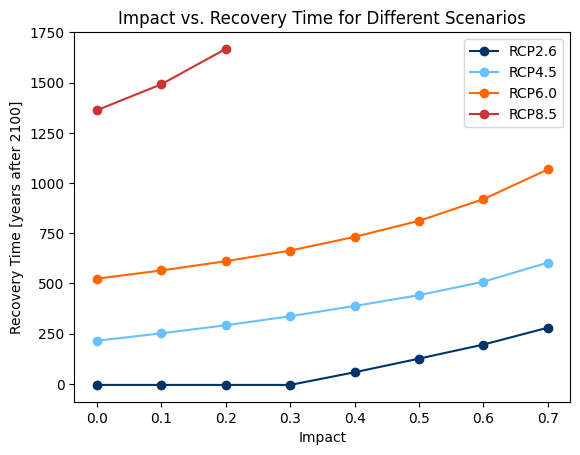

In [84]:
return_time_data['Recovery Time [yrs after 2100]'] = pd.to_numeric(return_time_data['Recovery Time [yrs after 2100]'], errors='coerce')

fig, ax = plt.subplots()

for scenario, color in colors_RCP.items():
    scenario_str = f'RCP{scenario}'
    subset = return_time_data[return_time_data['Scenario'] == scenario_str]
    ax.plot(subset['Impact'], subset['Recovery Time [yrs after 2100]'], marker='o', linestyle='-', color=color, label=scenario_str)

ax.set_xlabel('Impact')
ax.set_ylabel('Recovery Time [years after 2100]')
ax.set_title('Impact vs. Recovery Time for Different Scenarios')
ax.legend()
plt.savefig(os.path.join(output_dir, f'Impact_vs_RecoveryTime.png'), bbox_inches='tight')
plt.show()